<a href="https://colab.research.google.com/github/Sahana-Anbazhagan/Cpp/blob/master/Homework_1_Superpixels_Arun_Kumar_and_Sahana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1
<!-- Understanding and implementing SLIC Superpixels. -->
A superpixel can be defined as a group of pixels that share common characteristics. Simple Linear Iterative Clustering (SLIC) generates superpixels by clustering pixels based on their color similarity and proximity in the image plane. The purpose of this assignment is to understand and implement SLIC Superpixels.

Some pointers before we start:
- Please follow all submission guidlines which are posted on piazza.
- Ensure all outputs are displayed while rendering the PDF.
- Only modify the code blocks  which has a "TODO".
- Below you can see some outputs for an image of a cow. These images represent the kind of output that is expected. 
- Feel free to reach out to any of the TAs for any doubts/issues.

Let's download the dataset first.

In [17]:
!wget http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip

--2020-11-03 04:14:23--  http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.46.53.60, 2600:1408:5c00:396::e59, 2600:1408:5c00:3ad::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.46.53.60|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44119839 (42M) [application/octet-stream]
Saving to: ‘msrc_objcategimagedatabase_v1.zip.1’

msrc_objcategimaged 100%[===================>]  42.08M   103MB/s    in 0.4s    

2020-11-03 04:14:23 (103 MB/s) - ‘msrc_objcategimagedatabase_v1.zip.1’ saved [44119839/44119839]



In [18]:
!unzip --qq msrc_objcategimagedatabase_v1.zip

replace MSRC_ObjCategImageDatabase_v1/1_10_s.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


We only focus on six images in this assignment.

In [19]:
im_list = ['MSRC_ObjCategImageDatabase_v1/1_22_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/1_27_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/3_3_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/3_6_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/6_5_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/7_19_s.bmp']

In [20]:
#All important functions to plot, do not modify this block
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

def plot_image(im,title,xticks=[],yticks= [],isCv2 = True):
    """
    im :Image to plot
    title : Title of image 
    xticks : List of tick values. Defaults to nothing
    yticks :List of tick values. Defaults to nothing 
    cv2 :Is the image cv2 image? cv2 images are BGR instead of RGB. Default True
    """
    plt.figure()
    if isCv2:
        im = im[:,:,::-1]
    plt.imshow(im)
    plt.title(title)
    plt.xticks(xticks)
    plt.yticks(yticks)

def superpixel_plot(im,seg,title = "Superpixels"):
    """
    Given an image (nXmX3) and pixelwise class mat (nXm), 
    1. Consider each class as a superpixel
    2. Calculate mean superpixel value for each class
    3. Replace the RGB value of each pixel in a class with the mean value  
    
    Inputs:
    im: Input image
    seg: Segmentation map
    title: Title of the plot 
    
    Output: None
    Creates a plot    
    """
    clust = np.unique(seg)
    mapper_dict = {i: im[seg == i].mean(axis = 0)/255. for i in clust}

    seg_img =  np.zeros((seg.shape[0],seg.shape[1],3))
    for i in clust:
        seg_img[seg == i] = mapper_dict[i]
    
    plot_image(seg_img,title)
    
    return    

def rgb_segment(seg,n = None,plot = True,title=None,legend = True,color = None):
    """
    Given a segmentation map, get the plot of the classes
    """
    clust = np.unique(seg)
    if n is None:
        n = len(clust)
    if color is None:
        cm = plt.cm.get_cmap('hsv',n+1)
        # mapper_dict = {i:np.array(cm(i/n)) for i in clust}
        mapper_dict = {i:np.random.rand(3,) for i in clust} 
    #elif color == 'mean':
        #TODO..get the mean color of cluster center and assign that to mapper_dict

    seg_img =  np.zeros((seg.shape[0],seg.shape[1],3))
    for i in clust:
        seg_img[seg == i] = mapper_dict[i][:3]

    if plot: 
        plot_image(seg_img,title = title)
    if legend:
        # get the colors of the values, according to the 
        # colormap used by imshow
        patches = [ mpatches.Patch(color=mapper_dict[i], label=" : {l}".format(l=i) ) for i in range(n) ]
        # put those patched as legend-handles into the legend
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
        plt.grid(True)
        plt.show()

    return seg_img

Let's see what the six images are:

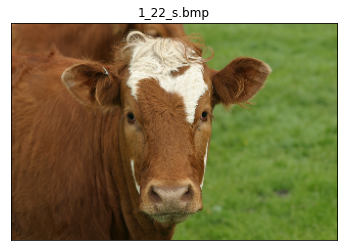

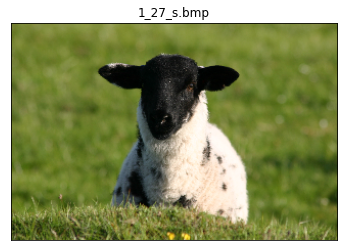

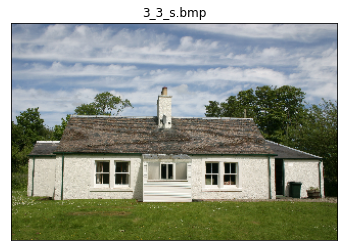

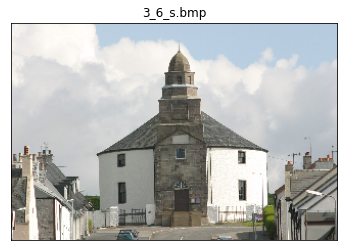

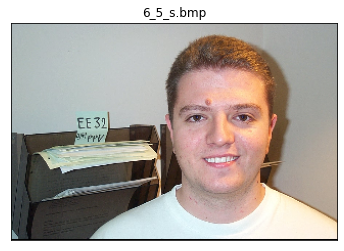

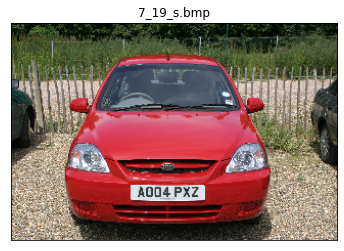

In [21]:
for i in im_list:
    plot_image(cv2.imread(i),i.split("/")[-1])

Get image and visualize it. Its a scenery with 3 elements. You can see the segmentation ground truth in the GT bitmap.  

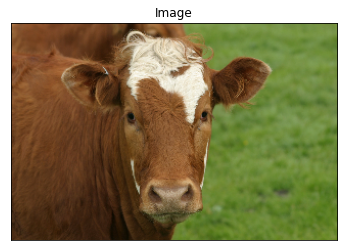

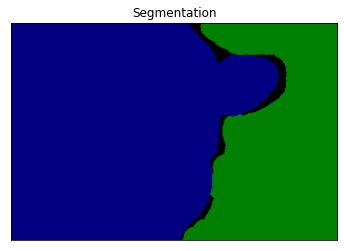

In [22]:
im = cv2.imread(im_list[0])
seg = cv2.imread(im_list[0].replace("_s","_s_GT"))

plot_image(im,"Image")
plot_image(seg,"Segmentation")


###Question 1: K-means on RGB
We know k-means clustering algorithm. It is an unsupervised algorithm which minimizes **ANSWER: **_Within cluster sum of squared Eucledian distances__.  

Complete the pixel clustering function. It should take input an image (dim = (n $\times$ m  $\times$ 3)) and number of clusters needed. 
Does K means clustering work on image pixels?
Let the number of clusters be K = 5, 10, 50




In [23]:
from sklearn.cluster import KMeans
import numpy as  np
import sklearn

def cluster_pixels(im, k_):
  img = im # Copying the image so that we can use original dimensions when needed
  # reshaping and converting the image into a 2D numpy array and randomizing the labels of individual pixels 
  image = img.reshape(-1,3)
  # Initializing k random labels to the means or centroids
  label = np.random.choice(len(image), k_, False)
  means = image[label,:]

  # Generating new labels and updating the existing labels by comparing distances with previous means
  # Looping through a fixed maximum number of iterations
  for k in range(1000):
    oldmeans = means
    # Euclidean distance
    dist = sklearn.metrics.pairwise_distances(image, means, metric = 'euclidean')
    # Assign clusters based on the distances
    clusters = np.argmin(dist, axis = 1)
    # print(clusters)

    # reshaping and flattening to get the 2D cluster indices
    clusters = np.array(clusters).reshape(im.shape[0], im.shape[1])
  # print(clusters.shape)

    # Updating centroids - Checking if the clusters has received a new point and updating it, else retaining the old mean values
    # means = np.array([image[clusters == k].mean(axis = 0) for k in range(k_)])
    # print(mean)
  return clusters

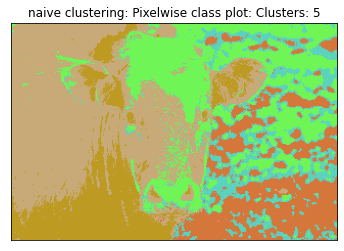

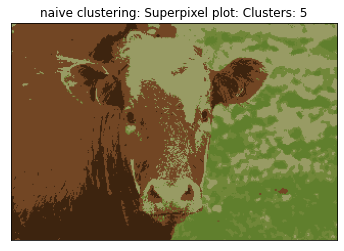

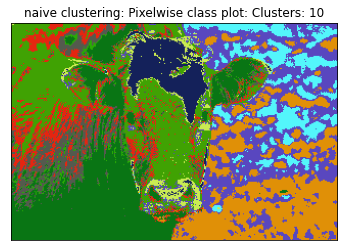

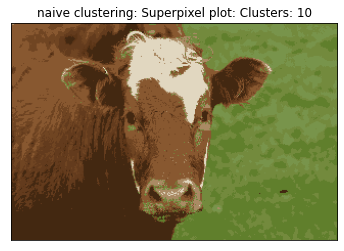

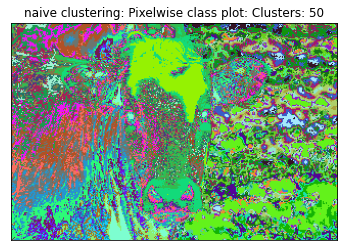

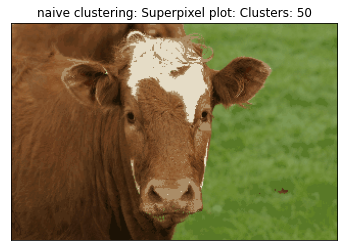

In [24]:
for k in [5,10,50]:
    clusters = cluster_pixels(im,k)
    _ = rgb_segment(clusters,n = k, title =  "naive clustering: Pixelwise class plot: Clusters: " + str(k),legend = False)
    superpixel_plot(im,clusters,title =  "naive clustering: Superpixel plot: Clusters: "+ str(k))

###Question 2: Now that you have a function handy, we have a slightly complex task

Instead of making clustering run on RGB space, run the clustering on RGBXY space. What advantages does that give us? 
(try with clusters = 5, 10, 25, 50, 150)

In [25]:
from sklearn.cluster import KMeans
import numpy as  np
import sklearn

def cluster_rgbxy(im,k_):
  img = im # Making a copy of the image for getting original dimensions later
# img = cv2.imread(im_list[0])
# k_ = 5

  imgRGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # Getting the image to RGB format
  # plot_image(imgRGB,"RGB Image")

  # Extracting the x and y components from the image individually and merging the 2 to form a 2D array
  x, y = np.meshgrid(np.linspace(0, im.shape[0] - 1, im.shape[0]),  np.linspace(0, im.shape[1] - 1, im.shape[1]), indexing = 'ij')
  # Stacking these over to get the image
  image = np.stack((im[:,:,0],im[:,:,1], im[:,:,2], x, y), axis = 2)

  # Reshaping the image to have r, g, b, x, y channels
  imageXY = image.reshape(-1, 5)
  # Initializing k random labels to the means or centroids
  labelXY = np.random.choice(len(imageXY), k_, False)
  meansXY = imageXY[labelXY,:]

  # Generating new labels and updating the existing labels by comparing distances with previous means
  # Looping through a fixed maximum number of iterations
  for k in range(1000):
    oldmeansXY = meansXY
    # Euclidean distance
    distance = sklearn.metrics.pairwise_distances(imageXY, meansXY, metric = 'euclidean')
    # Assign clusters based on the distances
    clustersXY = np.argmin(distance, axis = 1)
    # print(clusters)

    # Reshaping and flattening to get the 2D cluster indices
    clustersXY = np.array(clustersXY).reshape(im.shape[0], im.shape[1])
  # print(clustersXY.shape)
  return clustersXY

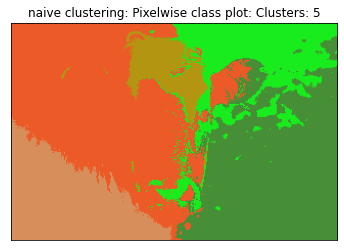

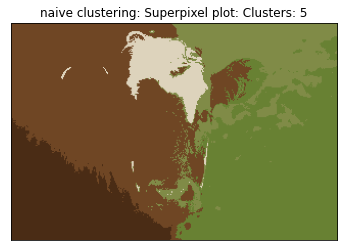

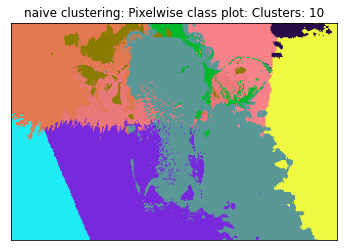

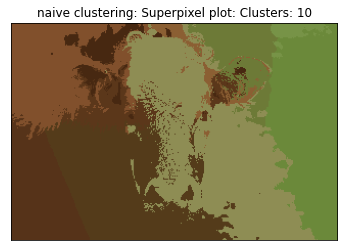

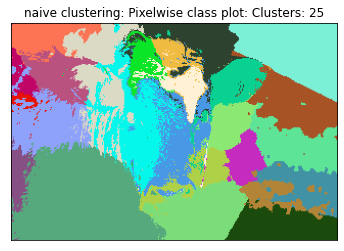

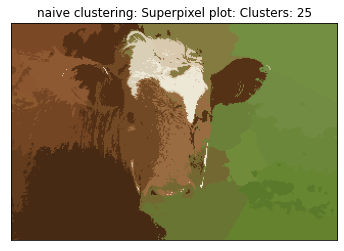

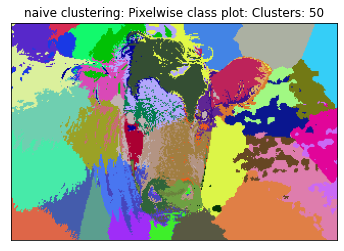

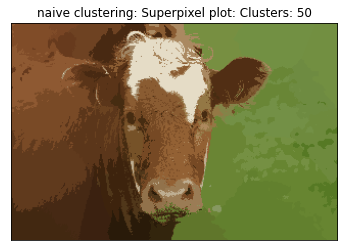

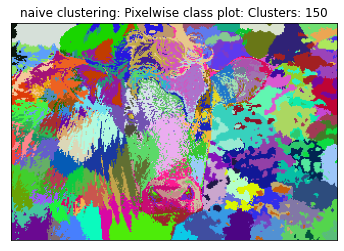

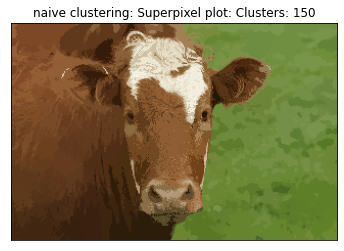

In [26]:
#TODO: clustering r,b,g,x,y values 
#try k = 20,80,200,400,800

for k in [5, 10, 25, 50, 150]:
    clusters = cluster_rgbxy(im,k)
    _ = rgb_segment(clusters,n = k, title =  "naive clustering: Pixelwise class plot: Clusters: " + str(k),legend = False)
    superpixel_plot(im,clusters,title =  "naive clustering: Superpixel plot: Clusters: "+ str(k))


###  Modified k-means with weighted distances. 

 Let $cluster\_center_i$ represent $i^{th}$ cluster center, $cluster\_center_i^{rgb}$ denote the RGB value and $cluster\_center_i^{xy}$ be the corresponding coordinate of the center pixel, respectively.
 
 Let $x_{rgb}$ be the the RGB value of a pixel, and let $x_{xy}$ be the corresponding pixel's coordinate.
 <!-- Let $x_{xy}$ be the coordinate of $x_{rgb}$ -->

$distance(x_{rgb},x_{xy}) = \lambda_1 * euclidean(x_{rgb},cluster\_center_{i}^{rgb})  + \lambda_2 * euclidean(x_{xy},cluster\_center_{i}^{xy})$



Find good values for hyperparmeters $\lambda_1$ and $\lambda_2$ (try on 250 clusters)

In [27]:
def MK_means(image, k, lambda_1, lambda_2, max_iters, channels):
    
    # Reshaping the input images

    img_vector = image.reshape(-1,channels)
    
    # Pick indices of k random points
    index = np.random.choice(len(img_vector), k, replace = False)
    
    # Initialize the centroids
    k_centroids = img_vector[index,:] 
    
    for _ in range(max_iters):
        
        previous_centroids = k_centroids
        
        #Compute the distances. Add the weights lambda 1 and lambda 2 to compute distances between 
        # rgb pixels and cluster center rgb value followed by xy pixels and cluster center xy values
        
        pixel_distance = (lambda_1 * distance(img_vector[:,0:3], previous_centroids[:,0:3], k) 
                          + lambda_2 * distance(img_vector[:,3:5], previous_centroids[:,3:5],k))
        
        # Find the closest cluster
        cluster_labels = np.argmin(pixel_distance, axis = 1)
        
        # Compute the new centroids
        k_centroids = update_centroids(img_vector, cluster_labels, k)
        
        if np.all(previous_centroids == k_centroids):
            break
    
    return cluster_labels

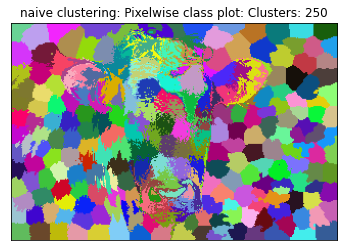

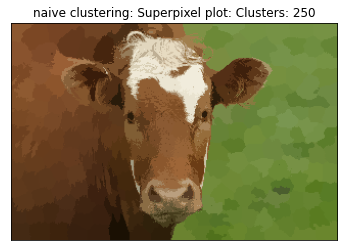

In [28]:
#TODO: clustering r,b,g,x,y values with lambdas and display outputs
def cluster_rgbxy(im,k, lambda_1, lambda_2):
    """
    Given image im and asked for k clusters, return nXm size 2D array
    segmap[0,0] is the class of pixel im[0,0,:]
    """
    #assert 1==2,"NOT IMPLEMENTED"
    x_cr = np.linspace(0,  im.shape[0]-1, num = im.shape[0])
    y_cr = np.linspace(0,  im.shape[1]-1, num = im.shape[1])
    x_coordinate, y_coordinate = np.meshgrid(x_cr,y_cr,indexing = 'ij')
    im = np.stack((im[:,:,0],im[:,:,1], im[:,:,2], x_coordinate, y_coordinate), axis = 2)
    segmap = MK_means(im,k,lambda_1,lambda_2,max_iters = 1000,channels=5)
    segmap = np.array(segmap).reshape(im.shape[0], im.shape[1])
    return segmap

for k in [250]:
    clusters = cluster_rgbxy(im,k,lambda_1=50,lambda_2=200)
    _ = rgb_segment(clusters,n = k, title =  "naive clustering: Pixelwise class plot: Clusters: " + str(k),legend = False)
    superpixel_plot(im,clusters,title =  "naive clustering: Superpixel plot: Clusters: "+ str(k))


HYPERPARAMETERS TESTED:

${\lambda_1} = 20, {\lambda_2} = 20$

${\lambda_1} = 20, {\lambda_2} = 40$

${\lambda_1} = 40, {\lambda_2} = 40$

${\lambda_1} = 40, {\lambda_2} = 80$

${\lambda_1} = 40, {\lambda_2} = 120$

${\lambda_1} = 80, {\lambda_2} = 80$

${\lambda_1} = 80, {\lambda_2} = 100$

${\lambda_1} = 80, {\lambda_2} = 120$

${\lambda_1} = 80, {\lambda_2} = 150$

${\lambda_1} = 100, {\lambda_2} = 250$

${\lambda_1} = 50, {\lambda_2} = 200$

Best Values: ${\lambda_1} = 50, {\lambda_2} = 200$

When the weight on euclidean distance for the xy dimensions is increased ,that is ${\lambda_2}$ ,the algorithm tends to output better superpixels.

###Question 3: SLIC

It doesn't look like we have a very favourable outcome with superpixels simply being implemented as K-means. Can we do better? Have a look at the SLIC paper [here](https://www.iro.umontreal.ca/~mignotte/IFT6150/Articles/SLIC_Superpixels.pdf). Incorporate S and m and redefine your distance metric as per the paper.


In [29]:
def slic_algo(k, image, s, m=20):
    """
        Inputs:
        k: the number of clusters
        image: the input image
        s: parameter for slic algo
        m: hyperparameter for slic algo
        
        Output:
        cluster_labels: the cluster number for each sample
    """
    # initialize the cluster centers
    kcentroids = np.array([])
    height_image = int(image.shape[0])
    width_image = int(image.shape[1])
    curr_height = int(s // 2)
    curr_width = int(s // 2)
    flag = 0
    while curr_height < height_image:
        while curr_width < width_image:
            if len(kcentroids) == 0:
                kcentroids = np.array([curr_height, curr_width, image[curr_height, curr_width, 0], image[curr_height, curr_width, 1], image[curr_height, curr_width, 2]])
            else:
                flag = 1
                kcentroids = np.vstack((kcentroids, np.array([curr_height, curr_width, image[curr_height, curr_width, 0], image[curr_height, curr_width, 1], image[curr_height, curr_width, 2]])))
            curr_width += s
            curr_width = int(curr_width)
            
            # if k clusters found
            if len(kcentroids) == k and flag == 1:
                break
        curr_width = s // 2
        curr_width = int(curr_width)
        curr_height += s
        curr_height = int(curr_height)
        
        # if k clusters found
        if len(kcentroids) == k and flag == 1:
            break
        
    # perturb cluster centers to lowest gradient position
    for i in range(0, len(kcentroids)):
        cluster_x = int(kcentroids[i, 0])
        cluster_y = int(kcentroids[i, 1])
        if (cluster_x+1) >= image.shape[0]:
            cluster_x = int(image.shape[0]-2)
        if (cluster_y+1) >= image.shape[1]:
            cluster_y = int(image.shape[1]-2)
        curr_grad = int(image[cluster_x+1, cluster_y+1, 0]) - int(image[cluster_x, cluster_y, 0]) + int(image[cluster_x+1, cluster_y+1, 1]) - int(image[cluster_x, cluster_y, 1]) + int(image[cluster_x+1, cluster_y+1, 2]) - int(image[cluster_x, cluster_y, 2])
        for dh in range(-1, 2):
            for dw in range(-1, 2):
                new_cluster_x = int(cluster_x + dh)
                new_cluster_y = int(cluster_y + dw)
                if (new_cluster_x+1) >= image.shape[0]:
                    new_cluster_x = image.shape[0]-2
                if (new_cluster_y+1) >= image.shape[1]:
                    new_cluster_y = image.shape[1]-2
                new_grad = int(image[new_cluster_x+1, new_cluster_y+1, 0]) - int(image[new_cluster_x, new_cluster_y, 0]) + int(image[new_cluster_x+1, new_cluster_y+1, 1]) - int(image[new_cluster_x, new_cluster_y, 1]) + int(image[new_cluster_x+1, new_cluster_y+1, 2]) - int(image[new_cluster_x, new_cluster_y, 2])
                
                if new_grad < curr_grad:
                    kcentroids[i, 0] = int(new_cluster_x)
                    kcentroids[i, 1] = int(new_cluster_y)
                    kcentroids[i, 2] = image[int(kcentroids[i, 0]), int(kcentroids[i, 1]), 0]
                    kcentroids[i, 3] = image[int(kcentroids[i, 0]), int(kcentroids[i, 1]), 1]
                    kcentroids[i, 4] = image[int(kcentroids[i, 0]), int(kcentroids[i, 1]), 2]
                    curr_grad = new_grad
    
    # run slic with initialized cluster centers
    cluster_labels = np.zeros((image.shape[0], image.shape[1]))
    for i in range(0, 100):
        
        # for each cluster
        pixels_distance = np.ones((image.shape[0], image.shape[1]))*1000000000000
        cluster_labels = np.ones((image.shape[0], image.shape[1]))*-1
        new_kcentroids = np.zeros((len(kcentroids), 3))
        for j in range(0, len(kcentroids)):
            
            # scan 2S x 2S region
            for h in range(int(kcentroids[j, 0]-s), int(kcentroids[j, 0]+s)):
                if h<0 or h>=image.shape[0]:
                    continue
                
                for w in range(int(kcentroids[j, 1]-s), int(kcentroids[j, 1]+s)):
                    if w<0 or w>=image.shape[1]:
                        continue
                    
                    distance_lab = np.sqrt((int(image[h, w, 0]) - kcentroids[j, 2])*(int(image[h, w, 0]) - kcentroids[j, 2]) + (int(image[h, w, 1]) - kcentroids[j, 3])*(int(image[h, w, 1]) - kcentroids[j, 3]) + (int(image[h, w, 2]) - kcentroids[j, 4])*(int(image[h, w, 2]) - kcentroids[j, 4]))
                    distance_xy = np.sqrt((h-kcentroids[j, 0])*(h-kcentroids[j, 0]) + (w-kcentroids[j, 1])*(w-kcentroids[j, 1]))
                    distance = distance_lab + (m/s)*distance_xy
                        
                    if distance<pixels_distance[h, w]:
                        pixels_distance[h, w] = distance
                        if cluster_labels[h, w] != -1:
                            new_kcentroids[int(cluster_labels[h, w]), 0] -= h
                            new_kcentroids[int(cluster_labels[h, w]), 1] -= w
                            new_kcentroids[int(cluster_labels[h, w]), 2] -= 1
                        cluster_labels[h, w] = j
                        new_kcentroids[j, 0] += h
                        new_kcentroids[j, 1] += w
                        new_kcentroids[j, 2] += 1
        
        # # update cluster centers
        # for j in range(0, len(kcentroids)):
        #     kcentroids[j, 0] = int(new_kcentroids[j, 0] // new_kcentroids[j, 2])
        #     kcentroids[j, 1] = int(new_kcentroids[j, 1] // new_kcentroids[j, 2])
        #     kcentroids[j, 2] = image[int(kcentroids[j, 0]), int(kcentroids[j, 1]), 0]
        #     kcentroids[j, 3] = image[int(kcentroids[j, 0]), int(kcentroids[j, 1]), 1]
        #     kcentroids[j, 4] = image[int(kcentroids[j, 0]), int(kcentroids[j, 1]), 2]
    
    # return cluster number for each pixel of image
    return cluster_labels

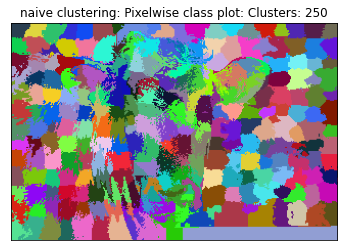

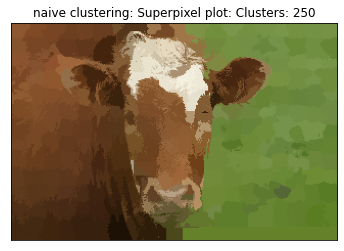

In [30]:
#TODO diplay your SLIC results.
def cluster_labxy(im,k):
    s = np.sqrt((im.shape[0]*im.shape[1]) / k)
    lab_image = cv2.cvtColor(im, cv2.COLOR_BGR2LAB)
    segmap = slic_algo(k, lab_image, s)
    segmap = np.array(segmap).reshape(im.shape[0], im.shape[1])
    return segmap

for k in [250]:
    clusters = cluster_labxy(im,k)
    _ = rgb_segment(clusters,n = k, title =  "naive clustering: Pixelwise class plot: Clusters: " + str(k),legend = False)
    superpixel_plot(im,clusters,title =  "naive clustering: Superpixel plot: Clusters: "+ str(k))


## Bonus Question:
Enforce connectivity: There are many superpixels which are very small and disconnected from each other. Try to merge them with larger superpixels

O(N) algorithm:
1. Set a minimum size of superpixel
2. If the area of a region is smaller than a threshold, we assign it to the nearest cluster 


In [31]:
def slic_algo(k, image, s, m=20):
    """
        Inputs:
        k: the number of clusters
        image: the input image
        s: parameter for slic algo
        m: hyperparameter for slic algo
        
        Output:
        cluster_labels: the cluster number for each sample
    """
    # initialize the cluster centers
    kcentroids = np.array([])
    height_image = int(image.shape[0])
    width_image = int(image.shape[1])
    curr_height = int(s // 2)
    curr_width = int(s // 2)
    flag = 0
    while curr_height < height_image:
        while curr_width < width_image:
            if len(kcentroids) == 0:
                kcentroids = np.array([curr_height, curr_width, image[curr_height, curr_width, 0], image[curr_height, curr_width, 1], image[curr_height, curr_width, 2]])
            else:
                flag = 1
                kcentroids = np.vstack((kcentroids, np.array([curr_height, curr_width, image[curr_height, curr_width, 0], image[curr_height, curr_width, 1], image[curr_height, curr_width, 2]])))
            curr_width += s
            curr_width = int(curr_width)
            
            # if k clusters found
            if len(kcentroids) == k and flag == 1:
                break
        curr_width = s // 2
        curr_width = int(curr_width)
        curr_height += s
        curr_height = int(curr_height)
        
        # if k clusters found
        if len(kcentroids) == k and flag == 1:
            break
        
    # perturb cluster centers to lowest gradient position
    for i in range(0, len(kcentroids)):
        cluster_x = int(kcentroids[i, 0])
        cluster_y = int(kcentroids[i, 1])
        if (cluster_x+1) >= image.shape[0]:
            cluster_x = int(image.shape[0]-2)
        if (cluster_y+1) >= image.shape[1]:
            cluster_y = int(image.shape[1]-2)
        curr_grad = int(image[cluster_x+1, cluster_y+1, 0]) - int(image[cluster_x, cluster_y, 0]) + int(image[cluster_x+1, cluster_y+1, 1]) - int(image[cluster_x, cluster_y, 1]) + int(image[cluster_x+1, cluster_y+1, 2]) - int(image[cluster_x, cluster_y, 2])
        for dh in range(-1, 2):
            for dw in range(-1, 2):
                new_cluster_x = int(cluster_x + dh)
                new_cluster_y = int(cluster_y + dw)
                if (new_cluster_x+1) >= image.shape[0]:
                    new_cluster_x = image.shape[0]-2
                if (new_cluster_y+1) >= image.shape[1]:
                    new_cluster_y = image.shape[1]-2
                new_grad = int(image[new_cluster_x+1, new_cluster_y+1, 0]) - int(image[new_cluster_x, new_cluster_y, 0]) + int(image[new_cluster_x+1, new_cluster_y+1, 1]) - int(image[new_cluster_x, new_cluster_y, 1]) + int(image[new_cluster_x+1, new_cluster_y+1, 2]) - int(image[new_cluster_x, new_cluster_y, 2])
                
                if new_grad < curr_grad:
                    kcentroids[i, 0] = int(new_cluster_x)
                    kcentroids[i, 1] = int(new_cluster_y)
                    kcentroids[i, 2] = image[int(kcentroids[i, 0]), int(kcentroids[i, 1]), 0]
                    kcentroids[i, 3] = image[int(kcentroids[i, 0]), int(kcentroids[i, 1]), 1]
                    kcentroids[i, 4] = image[int(kcentroids[i, 0]), int(kcentroids[i, 1]), 2]
                    curr_grad = new_grad
    
    # run slic with initialized cluster centers
    cluster_labels = np.zeros((image.shape[0], image.shape[1]))
    for i in range(0, 100):
        
        # for each cluster
        pixels_distance = np.ones((image.shape[0], image.shape[1]))*1000000000000
        cluster_labels = np.ones((image.shape[0], image.shape[1]))*-1
        new_kcentroids = np.zeros((len(kcentroids), 3))
        for j in range(0, len(kcentroids)):
            
            # scan 2S x 2S region
            for h in range(int(kcentroids[j, 0]-s), int(kcentroids[j, 0]+s)):
                if h<0 or h>=image.shape[0]:
                    continue
                
                for w in range(int(kcentroids[j, 1]-s), int(kcentroids[j, 1]+s)):
                    if w<0 or w>=image.shape[1]:
                        continue
                    
                    distance_lab = np.sqrt((int(image[h, w, 0]) - kcentroids[j, 2])*(int(image[h, w, 0]) - kcentroids[j, 2]) + (int(image[h, w, 1]) - kcentroids[j, 3])*(int(image[h, w, 1]) - kcentroids[j, 3]) + (int(image[h, w, 2]) - kcentroids[j, 4])*(int(image[h, w, 2]) - kcentroids[j, 4]))
                    distance_xy = np.sqrt((h-kcentroids[j, 0])*(h-kcentroids[j, 0]) + (w-kcentroids[j, 1])*(w-kcentroids[j, 1]))
                    distance = distance_lab + (m/s)*distance_xy
                        
                    if distance<pixels_distance[h, w]:
                        pixels_distance[h, w] = distance
                        if cluster_labels[h, w] != -1:
                            new_kcentroids[int(cluster_labels[h, w]), 0] -= h
                            new_kcentroids[int(cluster_labels[h, w]), 1] -= w
                            new_kcentroids[int(cluster_labels[h, w]), 2] -= 1
                        cluster_labels[h, w] = j
                        new_kcentroids[j, 0] += h
                        new_kcentroids[j, 1] += w
                        new_kcentroids[j, 2] += 1

    for c in kcentroids:
      pixel_set = set(c[cluster_labels])
      bfs_queue = []
      clust_x = int(kcentroids[c, 0])
      clust_y = int(kcentroids[c, 1])
      cluster_center_pixel = (clust_y, clust_x)
      
      if cluster_center_pixel == pixel_set:
        bfs_queue.append(cluster_center_pixel)
        pixel_set.remove(cluster_center_pixel)
      elif pixel_set:
        bfs_queue.append(next(iter(pixel_set)))

      while bfs_queue:
        pixel = bfs_queue.pop()
        for p in ((pixel[0] - 1, pixel[1]), (pixel[0] + 1, pixel[1]), (pixel[0], pixel[1] - 1), (pixel[0], pixel[1] + 1)):
          if (p[0] >= 0) and (p[0] < self.height) and (p[1] >= 0) and (p[1] < self.width) and (p in pixel_set):
            bfs_queue.append(p)
            pixel_set.remove(p)
      
      while pixel_set:
        bfs_queue.append(next(iter(pixel_set)))
        while bfs_queue:
          pixel = bfs_queue.pop()
          for p in ((pixel[0] - 1, pixel[1]), (pixel[0] + 1, pixel[1]), (pixel[0], pixel[1] - 1), (pixel[0], pixel[1] + 1)):
            if (p[0] >= 0) and (p[0] < self.height) and (p[1] >= 0) and (p[1] < self.width):            
              if p in c[cluster_labels]:
                bfs_queue.append(p)


    # return cluster number for each pixel of image
    return cluster_labels



In [32]:
#TODO diplay your SLIC results.
def cluster_labxy(im,k):
    s = np.sqrt((im.shape[0]*im.shape[1]) / k)
    lab_image = cv2.cvtColor(im, cv2.COLOR_BGR2LAB)
    segmap = slic_algo(k, lab_image, s)
    segmap = np.array(segmap).reshape(im.shape[0], im.shape[1])
    return segmap

for k in [250]:
    clusters = cluster_labxy(im,k)
    _ = rgb_segment(clusters,n = k, title =  "naive clustering: Pixelwise class plot: Clusters: " + str(k),legend = False)
    superpixel_plot(im,clusters,title =  "naive clustering: Superpixel plot: Clusters: "+ str(k))


IndexError: ignored

## Your File
Link to your colab/ipynb file: https://colab.research.google.com/drive/1EwjEJ_-i0TtLm4Ob5o6f129Ytbuqe_0c?usp=sharing
